In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install bayesian-optimization

In [8]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from bayes_opt import BayesianOptimization

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten
from keras.optimizers import Adam
from keras.api._v2.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')
# disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [9]:
import os
import pandas as pd

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [10]:
# get the index of the first alphabet in the string after the 9th index
def get_index(string):
    for i in range(9,len(string)):
        if string[i].isalpha():
            return i
    return -1

def read_files():

    # get all the .dat files in the dataset folder
    data_dir = '/content/drive/MyDrive/OpportunityUCIDataset/dataset'
    files = os.listdir(data_dir)
    files = [f for f in files if f.endswith('.dat')]

    # separate the ADL and Drill files
    list_of_files = [f for f in files if f.find('Drill') == -1]

    columns=[]

    with open(data_dir+"/column_names.txt",'r') as f:
        lines = f.read().splitlines()

        for line in lines:
            if line.find('Column') != -1:
                columns.append(line[get_index(line):].split(";")[0])

    data_collection = pd.DataFrame(columns=columns)
    for _, file in enumerate(list_of_files):

        proc_data = pd.read_table(data_dir+"/"+file, header=None, sep='\s+')
        proc_data.columns = columns
        data_collection = pd.concat([data_collection, proc_data])

    data_collection.reset_index(drop=True, inplace=True)

    return data_collection

In [11]:
data_collection = read_files()

data_collection

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,0,87.0,975.0,-287.0,11.0,1001.0,163.0,95.0,975.0,152.0,...,5789.0,2907.0,1447.0,0,0,0,0,0,0,0
1,33,124.0,978.0,-389.0,-7.0,1014.0,199.0,124.0,968.0,123.0,...,5789.0,2908.0,1443.0,0,0,0,0,0,0,0
2,67,102.0,996.0,-440.0,-49.0,1024.0,193.0,127.0,1001.0,113.0,...,5789.0,2910.0,1440.0,0,0,0,0,0,0,0
3,100,59.0,861.0,-384.0,-9.0,1023.0,202.0,110.0,1007.0,106.0,...,5789.0,2912.0,1440.0,0,0,0,0,0,0,0
4,133,119.0,946.0,-426.0,-22.0,1026.0,188.0,98.0,1001.0,92.0,...,5791.0,2915.0,1442.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644630,1017390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
644631,1017423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
644632,1017456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
644633,1017490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0


In [12]:
def dataCleaning(data_collection):
    data_collection = data_collection.dropna(thresh=int(len(data_collection.columns) * 0.9), inplace=False) #drop the columns which has NaN over 10%

    data_collection = data_collection.fillna(0)

    data_collection = data_collection.apply(pd.to_numeric, errors = 'coerce') #removal of non numeric data in cells

    data_collection = data_collection.interpolate()

    return data_collection

In [13]:
cleaned_dataCollection = dataCleaning(data_collection)

cleaned_dataCollection

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,0,87.0,975.0,-287.0,11.0,1001.0,163.0,95.0,975.0,152.0,...,5789.0,2907.0,1447.0,0,0,0,0,0,0,0
1,33,124.0,978.0,-389.0,-7.0,1014.0,199.0,124.0,968.0,123.0,...,5789.0,2908.0,1443.0,0,0,0,0,0,0,0
2,67,102.0,996.0,-440.0,-49.0,1024.0,193.0,127.0,1001.0,113.0,...,5789.0,2910.0,1440.0,0,0,0,0,0,0,0
3,100,59.0,861.0,-384.0,-9.0,1023.0,202.0,110.0,1007.0,106.0,...,5789.0,2912.0,1440.0,0,0,0,0,0,0,0
4,133,119.0,946.0,-426.0,-22.0,1026.0,188.0,98.0,1001.0,92.0,...,5791.0,2915.0,1442.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644088,999323,243.0,951.0,311.0,-79.0,919.0,368.0,293.0,951.0,282.0,...,5756.0,2160.0,1458.0,0,0,0,0,0,0,0
644089,999357,179.0,950.0,368.0,-97.0,919.0,365.0,304.0,934.0,239.0,...,5755.0,2158.0,1457.0,0,0,0,0,0,0,0
644090,999390,255.0,915.0,377.0,-137.0,921.0,405.0,285.0,940.0,239.0,...,5755.0,2156.0,1455.0,0,0,0,0,0,0,0
644091,999423,406.0,865.0,356.0,-149.0,957.0,366.0,275.0,962.0,212.0,...,5756.0,2154.0,1454.0,0,0,0,0,0,0,0


In [14]:
def reset_label(dataCollection):

    labels = pd.read_csv('/content/drive/MyDrive/OpportunityUCIDataset/dataset/label_legend.txt', sep='   -   ', header=0)

    track_dict = {}

    for track in labels['Track name'].unique():
        track_dict[track] = dict(labels.loc[labels['Track name'] == track][["Unique index", "Label name"]].to_numpy())

    for track in track_dict:
        if track == 'Locomotion':
            track_dict[track][1] = 1
            track_dict[track][2] = 2
            track_dict[track][4] = 3
            track_dict[track][5] = 0
        else:
            i= 0
            for key in track_dict[track]:
                track_dict[track][key] = i
                i += 1

    for track in track_dict:
        for key in track_dict[track]:
            dataCollection.loc[dataCollection[track] == key, track] = track_dict[track][key]

    return dataCollection

In [15]:
df = reset_label(dataCollection=cleaned_dataCollection)

df

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,0,87.0,975.0,-287.0,11.0,1001.0,163.0,95.0,975.0,152.0,...,5789.0,2907.0,1447.0,0,0,0,0,0,0,0
1,33,124.0,978.0,-389.0,-7.0,1014.0,199.0,124.0,968.0,123.0,...,5789.0,2908.0,1443.0,0,0,0,0,0,0,0
2,67,102.0,996.0,-440.0,-49.0,1024.0,193.0,127.0,1001.0,113.0,...,5789.0,2910.0,1440.0,0,0,0,0,0,0,0
3,100,59.0,861.0,-384.0,-9.0,1023.0,202.0,110.0,1007.0,106.0,...,5789.0,2912.0,1440.0,0,0,0,0,0,0,0
4,133,119.0,946.0,-426.0,-22.0,1026.0,188.0,98.0,1001.0,92.0,...,5791.0,2915.0,1442.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644088,999323,243.0,951.0,311.0,-79.0,919.0,368.0,293.0,951.0,282.0,...,5756.0,2160.0,1458.0,0,0,0,0,0,0,0
644089,999357,179.0,950.0,368.0,-97.0,919.0,365.0,304.0,934.0,239.0,...,5755.0,2158.0,1457.0,0,0,0,0,0,0,0
644090,999390,255.0,915.0,377.0,-137.0,921.0,405.0,285.0,940.0,239.0,...,5755.0,2156.0,1455.0,0,0,0,0,0,0,0
644091,999423,406.0,865.0,356.0,-149.0,957.0,366.0,275.0,962.0,212.0,...,5756.0,2154.0,1454.0,0,0,0,0,0,0,0


In [16]:
# normalize the data using standard scaler
def normalize_data(df):
    scaler = StandardScaler()
    df[df.columns[:-7]] = scaler.fit_transform(df[df.columns[:-7]])
    return df

df = normalize_data(df)

df

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,-1.410530,0.693260,0.434434,0.074936,-0.199117,0.621667,-0.455638,...,0.147947,0.811792,0.186199,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,-1.626921,0.626338,0.487110,0.200034,-0.108635,0.598101,-0.542260,...,0.147947,0.812691,0.178270,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,-1.735116,0.470187,0.527630,0.179184,-0.099275,0.709202,-0.572130,...,0.147947,0.814490,0.172322,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,-1.616313,0.618902,0.523578,0.210459,-0.152316,0.729402,-0.593039,...,0.147947,0.816289,0.172322,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,-1.705415,0.570570,0.535734,0.161809,-0.189757,0.709202,-0.634857,...,0.149055,0.818988,0.176287,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644088,1.407215,0.640278,0.298761,-0.141884,0.358651,0.102168,0.787298,0.418657,0.540867,-0.067329,...,0.129671,0.139901,0.208006,0,0,0,0,0,0,0
644089,1.407317,0.437804,0.297145,-0.020960,0.291729,0.102168,0.776873,0.452977,0.483633,-0.195770,...,0.129117,0.138102,0.206023,0,0,0,0,0,0,0
644090,1.407416,0.678242,0.240604,-0.001866,0.143014,0.110272,0.915871,0.393696,0.503833,-0.195770,...,0.129117,0.136303,0.202059,0,0,0,0,0,0,0
644091,1.407514,1.155955,0.159831,-0.046417,0.098399,0.256145,0.780348,0.362495,0.577900,-0.276418,...,0.129671,0.134504,0.200076,0,0,0,0,0,0,0


In [17]:
df.to_csv('/content/drive/MyDrive/OpportunityUCIDataset/dataset/preprocessed_data.csv', index=False)

<center><h1>Projet Robotique</h1></center>
<center><h2>Classification via CNN</h2></center>

# Importation des librairies

# Configaration GPU

In [18]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at:{}".format(device_name))
else:
  device_name="/device:CPU:0"
  print("No GPU")

Found GPU at:/device:GPU:0


# Importation du dataset

In [19]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
df = pd.read_csv("/content/drive/MyDrive/OpportunityUCIDataset/dataset/preprocessed_data.csv")

df

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,-1.410530,0.693260,0.434434,0.074936,-0.199117,0.621667,-0.455638,...,0.147947,0.811792,0.186199,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,-1.626921,0.626338,0.487110,0.200034,-0.108635,0.598101,-0.542260,...,0.147947,0.812691,0.178270,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,-1.735116,0.470187,0.527630,0.179184,-0.099275,0.709202,-0.572130,...,0.147947,0.814490,0.172322,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,-1.616313,0.618902,0.523578,0.210459,-0.152316,0.729402,-0.593039,...,0.147947,0.816289,0.172322,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,-1.705415,0.570570,0.535734,0.161809,-0.189757,0.709202,-0.634857,...,0.149055,0.818988,0.176287,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.640278,0.298761,-0.141884,0.358651,0.102168,0.787298,0.418657,0.540867,-0.067329,...,0.129671,0.139901,0.208006,0,0,0,0,0,0,0
606044,1.407317,0.437804,0.297145,-0.020960,0.291729,0.102168,0.776873,0.452977,0.483633,-0.195770,...,0.129117,0.138102,0.206023,0,0,0,0,0,0,0
606045,1.407416,0.678242,0.240604,-0.001866,0.143014,0.110272,0.915871,0.393696,0.503833,-0.195770,...,0.129117,0.136303,0.202059,0,0,0,0,0,0,0
606046,1.407514,1.155955,0.159831,-0.046417,0.098399,0.256145,0.780348,0.362495,0.577900,-0.276418,...,0.129671,0.134504,0.200076,0,0,0,0,0,0,0


# Fonctions diverses

# Fonctions de feature selection

In [21]:
def dim_reduction(df, n):
  pca = PCA(n_components=n)
  pca.fit(df)
  reducted_df = pca.fit_transform(df)
  columns_name = ['column'+str(i) for i in range(1, pca.n_components_+1)]
  return pd.DataFrame(reducted_df, columns=columns_name)


In [22]:
def correlation(dataset, cor):
    df = dataset.copy()
    col_corr = set()  # For storing unique value
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > cor: # absolute values to handle positive and negative correlations
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    df.drop(col_corr,axis = 1,inplace = True)
    return df

## Fonction de segmentation du dataset  

In [23]:
def data_segmentation(dataCollection, window_size, label): # segment the data and create a dataset with locomotion classes as labels

    loco_i = dataCollection.columns.get_loc(label)
    #convert the data frame to numpy array
    data = dataCollection.to_numpy()
    #segment the data
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0

    while start + window_size - 1 < n:
        end = start + window_size-1
        if data[start][loco_i] == data[end][loco_i] and data[start][-1] == data[end][-1] : # if the frame contains the same activity and from the file
            X.append(data[start:(end+1),:])
            y.append(data[start][loco_i])
            start += window_size//2 # 50% overlap
        else: # if the frame contains different activities or from different objects, find the next start point
            while start + window_size-1 < n:
                if data[start][loco_i] != data[start+1][loco_i]:
                    break
                start += 1
            start += 1

    return np.asarray(X), np.asarray(y)

## Fonction d'entrainement du modèle

In [24]:
from keras.layers import Conv1D, MaxPooling1D

def cnn_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, v):
    nbn_l = int(nbn_l)
    nbn_d = int(nbn_d)
    bs = int(bs)
    with tf.device(device_name):
        model = Sequential()
        model.add(Conv1D(filters=nbn_l, kernel_size=3, activation='relu', input_shape=X_train[0].shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=nbn_l//2, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(nbn_d, activation='elu'))
        model.add(Dropout(dp))
        model.add(Dense(nbn_l//2, activation='elu'))
        model.add(Dropout(dp))
        model.add(Dense(5, activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath='cnn_model_best.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5)

        history = model.fit(X_train, y_train, batch_size=bs, epochs=100, verbose=v, validation_data=(X_val, y_val), callbacks=[checkpointer, early_stopping])
        return history, model


## Fonction de la pipeline à utiliser

In [25]:
def pipeline(method, tresh, nbn_l, nbn_d, lr, bs, dp):
    if method <= 1:
        dataset = dim_reduction(df[df.columns[:-7]], tresh)
    elif method <= 2:
        dataset = correlation(df[df.columns[:-7]], tresh)

    labels = df[df.columns[-7:]]
    dataset = pd.concat([dataset, labels], axis=1)

    X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

    y = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

    history, model = cnn_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, 0)
    acc = history.history['val_accuracy'][-1]

    return acc

# Affinage de la pipeline via l'optimisation Bayesienne

In [26]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    'nbn_l': (256, 1024),
    'nbn_d': (256, 1024),
    'lr': (1e-6, 1e-2),
    'bs': (32, 512),
    'dp': (0.1, 0.5)
}

optimizer = BayesianOptimization(
    f=pipeline,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   |    bs     |    dp     |    lr     |  method   |   nbn_d   |   nbn_l   |   tresh   |
-------------------------------------------------------------------------------------------------------------

Epoch 1: val_accuracy improved from -inf to 0.11454, saving model to cnn_model_best.keras

Epoch 2: val_accuracy improved from 0.11454 to 0.14391, saving model to cnn_model_best.keras

Epoch 3: val_accuracy improved from 0.14391 to 0.28488, saving model to cnn_model_best.keras

Epoch 4: val_accuracy improved from 0.28488 to 0.39501, saving model to cnn_model_best.keras

Epoch 5: val_accuracy improved from 0.39501 to 0.43025, saving model to cnn_model_best.keras

Epoch 6: val_accuracy improved from 0.43025 to 0.49192, saving model to cnn_model_best.keras

Epoch 7: val_accuracy improved from 0.49192 to 0.52717, saving model to cnn_model_best.keras

Epoch 8: val_accuracy improved from 0.52717 to 0.54919, saving model to cnn_model_best.keras

Epoch 9: val_accuracy improved

# Préparation du dataset pour l'entrainement avec les hyperparamètres optimaux

## Feature selection

In [27]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']

if method <= 1:
  dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
  dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

dataset

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer RKN_ accY,InertialMeasurementUnit BACK gyroX,InertialMeasurementUnit BACK Quaternion1,InertialMeasurementUnit RUA gyroY,...,Accelerometer LOWERDRAWER accY,Accelerometer MIDDLEDRAWER accY,Accelerometer FRIDGE accX,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,-1.410530,0.693260,0.434434,0.255438,-0.221680,1.008702,-0.315880,...,0.175210,-0.401198,-0.424433,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,-1.626921,0.626338,0.487110,0.226841,-0.228620,1.005419,-0.065030,...,0.175210,-0.401198,-0.479332,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,-1.735116,0.470187,0.527630,0.181423,-0.226885,1.002137,-0.047878,...,0.175210,0.415356,-0.351234,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,-1.616313,0.618902,0.523578,0.230205,-0.107165,0.998855,0.016442,...,0.175210,-0.156232,-0.204835,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,-1.705415,0.570570,0.535734,0.247027,-0.081138,0.997214,-0.037158,...,0.175210,0.415356,-0.396983,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.640278,0.298761,-0.141884,0.358651,0.102168,0.270577,0.029907,-1.279080,0.190108,...,-0.944801,-0.401198,0.179460,0,0,0,0,0,0,0
606044,1.407317,0.437804,0.297145,-0.020960,0.291729,0.102168,0.159555,0.002146,-1.280722,-0.007142,...,-1.250258,-0.401198,0.106261,0,0,0,0,0,0,0
606045,1.407416,0.678242,0.240604,-0.001866,0.143014,0.110272,0.268895,0.092370,-1.280722,0.134363,...,-1.759354,0.415356,0.280108,0,0,0,0,0,0,0
606046,1.407514,1.155955,0.159831,-0.046417,0.098399,0.256145,0.248709,0.113191,-1.282363,0.190108,...,-0.232067,0.415356,0.097111,0,0,0,0,0,0,0


## Segmentation du dataset

In [ ]:
X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

X.shape, y.shape

## Division des données en train, val et test sets

In [29]:
# categorize the data
y = to_categorical(y)

# split the data into train, validation and test sets using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", X_train.shape)
print("Shape of the validation set: ", X_val.shape)
print("Shape of the test set: ", X_test.shape)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", y_train.shape)
print("Shape of the validation set: ", y_val.shape)
print("Shape of the test set: ", y_test.shape)

Shape of the train set:  (2761, 25, 68)
Shape of the validation set:  (681, 25, 68)
Shape of the test set:  (680, 25, 68)
Shape of the train set:  (2761, 5)
Shape of the validation set:  (681, 5)
Shape of the test set:  (680, 5)


# Entrainement du dataset avec les hyperparamètres optimaux

In [30]:
nbn_l = optimizer.max['params']['nbn_l']
nbn_d = optimizer.max['params']['nbn_d']
lr = optimizer.max['params']['lr']
dp = optimizer.max['params']['dp']
bs = optimizer.max['params']['bs']

history, model = cnn_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, 2)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.70485, saving model to cnn_model_best.keras
9/9 - 2s - loss: 4.5661 - accuracy: 0.4698 - val_loss: 0.7276 - val_accuracy: 0.7048 - 2s/epoch - 220ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.70485 to 0.83113, saving model to cnn_model_best.keras
9/9 - 0s - loss: 0.6396 - accuracy: 0.7309 - val_loss: 0.4647 - val_accuracy: 0.8311 - 319ms/epoch - 35ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.83113 to 0.91189, saving model to cnn_model_best.keras
9/9 - 0s - loss: 0.3256 - accuracy: 0.8714 - val_loss: 0.2051 - val_accuracy: 0.9119 - 296ms/epoch - 33ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.91189 to 0.97210, saving model to cnn_model_best.keras
9/9 - 0s - loss: 0.1127 - accuracy: 0.9631 - val_loss: 0.0861 - val_accuracy: 0.9721 - 291ms/epoch - 32ms/step
Epoch 5/100

Epoch 5: val_accuracy improved from 0.97210 to 0.97797, saving model to cnn_model_best.keras
9/9 - 0s - loss: 0.0398 - accur

# Evaluation du modèle

In [31]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.045447468757629395
Test accuracy: 0.9897058606147766


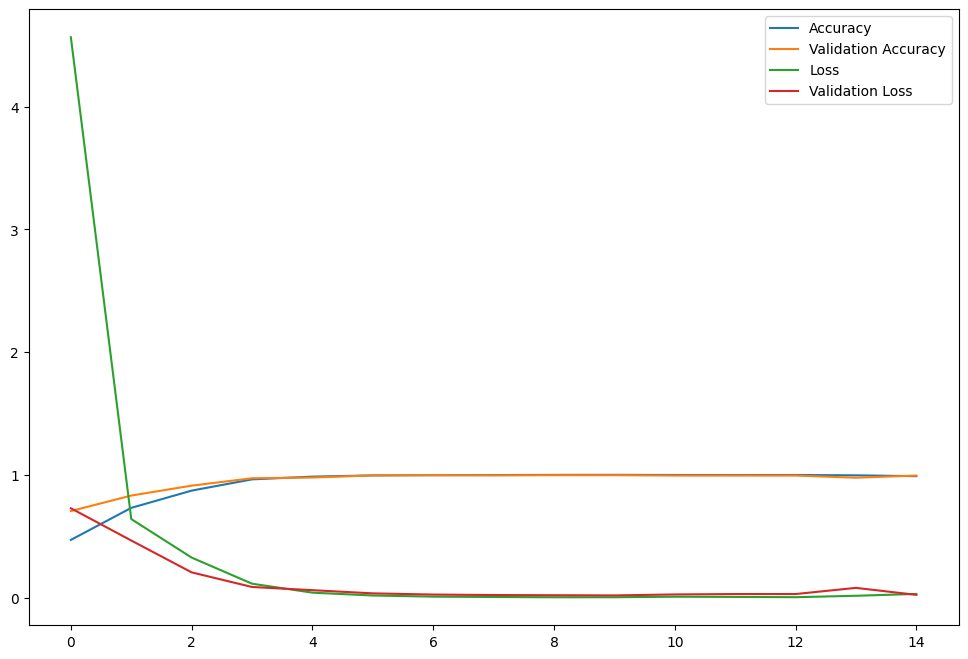

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [33]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test, y_pred)
s
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")

22/22 [==============================] - 0s 3ms/step


NameError: name 's' is not defined

In [ ]:
classification_report(y_test, y_pred).split("\n")

In [ ]:
z